## **Nocturne** | Performance analysis

## Setup

#### Supported metrics

- **Accuracy** to the expert actions. 
- **Euclidean distance** to the expert positions at a given state and timepoint (the L2 distance between the controlled object's XY
  location and its position in the logged history at the same timestep.) `np.linalg.norm(object_xy - log_xy, axis=-1)`
- **Mean absolute error to the expert speed, acceleration and steering wheel angle**

In [1]:
# Dependencies
import numpy as np
import glob
import pandas as pd
import seaborn as sns
import warnings
import torch
import logging
import os
import wandb
import matplotlib.pyplot as plt
from utils.evaluation import evaluate_policy
from utils.wrappers import LightNocturneEnvWrapper

from typing import Callable
from gym import spaces
from stable_baselines3.common.policies import ActorCriticPolicy
from networks.mlp_late_fusion import LateFusionMLP, LateFusionMLPPolicy

from utils.plot import plot_agent_trajectory
from utils.config import load_config_nb
from utils.eval import EvaluatePolicy
from utils.policies import load_policy

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
os.environ["WANDB_NOTEBOOK_NAME"] = "policy_performance_analysis.ipynb"

### Configurations

In [2]:
MAX_FILES = 100
DETERMINISTIC = True

# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")
model_config = load_config_nb("model_config")

# Set data path
env_config.data_path = "../data_full/train/"
env_config.val_data_path = "../data_full/valid/"
env_config.num_files = MAX_FILES

# Logging level set to INFO
LOGGING_LEVEL = "INFO"

# Scenes on which to evaluate the models
# Make sure file order is fixed
train_file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
train_eval_files = sorted([os.path.basename(file) for file in train_file_paths])

# Valid
valid_file_paths = glob.glob(f"{env_config.val_data_path}" + "/tfrecord*")
valid_eval_files = sorted([os.path.basename(file) for file in valid_file_paths])

### Helper functions

In [3]:
def render_traffic_scenes(
    eval_scenes, 
    policy, 
    run_name,
    deterministic=True, 
    group_name="RL_S100", 
    project_name="eval_hr_rl_policies"
    ):

    if deterministic:
        mode = "det"
    else:
        mode = "stoch"

    # Create run
    run = wandb.init(
        project=project_name,
        sync_tensorboard=True,
        group=group_name,
        name=f"{run_name}_{mode}",
    )

    avg_rew, std_rew = evaluate_policy(
        model=policy, 
        env=LightNocturneEnvWrapper(env_config),
        eval_files=eval_scenes,
        video_config=video_config,
        video_caption=f"",
        deterministic=deterministic,
        render=True,
    )

    run.finish()

### Logging

In [4]:
# Logging
logger = logging.getLogger()
logging.basicConfig(format="%(message)s")
logger.setLevel(LOGGING_LEVEL)

### 1. **Behavioral Cloning (BC)**


In [4]:
# Load trained human reference policy
human_policy = load_policy(
    data_path="../models/il",
    file_name="human_policy_10_scenes_2023_12_29", 
)

# Evaluate policy
evaluator = EvaluatePolicy(
    env_config=env_config, 
    exp_config=exp_config,
    policy=human_policy,
    eval_files=eval_files,
    log_to_wandb=False, 
    deterministic=False,
    reg_coef=0.0,
    return_trajectories=True,
)

df_il_res, df_il_trajs = evaluator._get_scores()
df_il_res['class'] = 'IL'

INFO:root:
 Evaluating policy on 50 files...
100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


In [5]:
df_il_res.round(3)

,run_id,traffic_scene,agents_controlled,reg_coef,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,class
0,None,tfrecord-00350-of-01000_410.json,2,0.0,0.094,1.526,0.127,5.253,1.066,0.000,1.000,0.000,IL
1,None,tfrecord-00349-of-01000_311.json,2,0.0,0.019,2.409,0.281,3.528,1.018,0.000,0.000,1.000,IL
2,None,tfrecord-00421-of-01000_364.json,9,0.0,0.067,1.970,0.164,7.574,1.055,0.000,0.222,0.667,IL
3,None,tfrecord-00243-of-01000_280.json,2,0.0,0.012,1.974,0.239,2.759,0.555,0.000,0.000,1.000,IL
4,None,tfrecord-00275-of-01000_483.json,3,0.0,0.050,1.833,0.220,3.999,0.621,0.000,0.667,0.333,IL
5,None,tfrecord-00201-of-01000_202.json,16,0.0,0.094,2.250,0.003,140.214,57.562,0.312,0.250,0.000,IL
6,None,tfrecord-00623-of-01000_242.json,8,0.0,0.058,2.032,0.375,205.846,114.555,0.125,0.000,0.375,IL
7,None,tfrecord-00316-of-01000_183.json,10,0.0,0.162,2.260,0.013,8.700,0.760,0.200,0.200,0.200,IL
8,None,tfrecord-00443-of-01000_487.json,6,0.0,0.025,2.143,0.294,9.119,1.796,0.000,0.333,0.500,IL
9,None,tfrecord-00908-of-01000_302.json,20,0.0,0.149,2.089,0.039,12.949,1.180,0.150,0.200,0.200,IL


In [6]:
scene_id = 'tfrecord-00012-of-01000_389.json'

df_scene = df_il_trajs[df_il_trajs.traffic_scene == scene_id]
print(f"Scene {scene_id}")
for agent_id in df_scene.agent_id.unique():
    agent_df = df_scene[df_scene.agent_id == agent_id]
    plot_agent_trajectory(agent_df, evaluator.env.action_space.n)

Scene tfrecord-00012-of-01000_389.json


### 2. **Human-regularized RL**

### Select policies to evaluate
- Add the model folder path and models to use
- Use `manage_models.py` to download models from `wandb` first

In [5]:
RL_POLICY_PATH = "../models/hr_rl"

# Scenes on which to evaluate the models
# rl_policy_paths = glob.glob(f"{RL_POLICY_PATH}" + "/*.pt")
# rl_policy_names = [os.path.basename(file)[:-3] for file in rl_policy_paths]
reg_weights = [0.0]

rl_policy_names = ['nocturne-hr-ppo-01_02_11_16_0.00_S100']

### 2.1 Evaluate policies on train dataset

In [6]:
env_config.data_path = "../data_full/train/"

df_hr_rl_train = pd.DataFrame()

for idx, policy in enumerate(rl_policy_names):

    print(f'Evaluating policy {policy}')

    eval_files = train_eval_files[:MAX_FILES]

    # Load trained model from artifact dir
    checkpoint = torch.load(f"{RL_POLICY_PATH}/{policy}.pt")
    policy = LateFusionMLPPolicy(
        observation_space=checkpoint['data']['observation_space'],
        action_space=checkpoint['data']['action_space'],
        lr_schedule=checkpoint['data']['lr_schedule'],
        use_sde=checkpoint['data']['use_sde'],
        env_config=env_config,
        mlp_class=LateFusionMLP,
        mlp_config=checkpoint['model_config'],
    )
    policy.load_state_dict(checkpoint['state_dict'])
    policy.eval();

    # Evaluate on scenes
    evaluator = EvaluatePolicy(
        env_config=env_config, 
        exp_config=exp_config,
        policy=policy,
        eval_files=eval_files,
        log_to_wandb=False, 
        deterministic=DETERMINISTIC,
        reg_coef=reg_weights[idx],
        return_trajectories=True,
    )

    df_rl_res, df_rl_trajs = evaluator._get_scores()

    df_hr_rl_train = pd.concat([df_hr_rl_train, df_rl_res])

df_hr_rl_train['Type'] = 'train'

Evaluating policy nocturne-hr-ppo-01_02_11_16_0.00_S100


INFO:root:
 Evaluating policy on 100 files...
100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


### 2.2 Evaluate policies on validation dataset

In [7]:
# Set data path
env_config.data_path = "../data_full/valid/"

df_hr_rl_valid = pd.DataFrame()

for idx, policy in enumerate(rl_policy_names):

    print(f'Evaluating policy {policy}')

    eval_files = valid_eval_files[:MAX_FILES]

    # Load trained model from artifact dir
    checkpoint = torch.load(f"{RL_POLICY_PATH}/{policy}.pt")
    policy = LateFusionMLPPolicy(
        observation_space=checkpoint['data']['observation_space'],
        action_space=checkpoint['data']['action_space'],
        lr_schedule=checkpoint['data']['lr_schedule'],
        use_sde=checkpoint['data']['use_sde'],
        env_config=env_config,
        mlp_class=LateFusionMLP,
        mlp_config=checkpoint['model_config'],
    )
    policy.load_state_dict(checkpoint['state_dict'])
    policy.eval();

    # Evaluate on scenes
    evaluator = EvaluatePolicy(
        env_config=env_config, 
        exp_config=exp_config,
        policy=policy,
        eval_files=eval_files,
        log_to_wandb=False, 
        deterministic=DETERMINISTIC,
        reg_coef=reg_weights[idx],
        return_trajectories=True,
    )

    df_rl_res, df_rl_trajs = evaluator._get_scores()

    df_hr_rl_valid = pd.concat([df_hr_rl_valid, df_rl_res])

df_hr_rl_valid['Type'] = 'valid'

INFO:root:
 Evaluating policy on 99 files...


Evaluating policy nocturne-hr-ppo-01_02_11_16_0.00_S100


  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:25<00:00,  3.95it/s]


In [10]:
# Concatenate
df_hr_rl = pd.concat([df_hr_rl_train, df_hr_rl_valid], ignore_index=True)
df_hr_rl['num_scenes'] = MAX_FILES

### 3. **Summary figures**

In [11]:
human_like_metrics = ['act_acc', 'accel_val_mae', 'steer_val_mae', 'pos_rmse', 'speed_mae']
performance_metrics = ['goal_rate', 'veh_edge_cr', 'veh_veh_cr']

In [14]:
df_hr_rl.groupby('Type')[performance_metrics].mean()

,goal_rate,veh_edge_cr,veh_veh_cr
Type,,,
train,0.10847,0.423477,0.243685
valid,0.11756,0.400298,0.235119


In [15]:
df_hr_rl.groupby('Type')[human_like_metrics].mean()

,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae
Type,,,,,
train,0.017106,2.202120,0.433476,13.270434,117.405705
valid,0.013951,2.198427,0.429229,11.465562,76.767855


In [16]:
df_hr_rl.head()

,run_id,reg_coef,traffic_scene,agent_id,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,Type,num_scenes
0,None,0.0,tfrecord-00001-of-01000_307.json,0,0.0750,2.326923,0.314103,7.041383,1.820937,0.0,0.0,0.0,train,100
1,None,0.0,tfrecord-00001-of-01000_307.json,1,0.0125,1.973684,0.350000,3.827434,1.104908,0.0,1.0,0.0,train,100
2,None,0.0,tfrecord-00001-of-01000_307.json,9,0.0000,2.088608,0.412025,8.245358,2.618147,0.0,0.0,0.0,train,100
3,None,0.0,tfrecord-00004-of-01000_378.json,0,0.0000,2.421053,0.503509,5.061539,1.413594,0.0,0.0,0.0,train,100
4,None,0.0,tfrecord-00004-of-01000_378.json,2,0.0000,1.500000,0.425000,1.942767,0.621620,1.0,0.0,0.0,train,100


### 3.1 What is the overall aggregated performance?

- Look at the error distribution
- What makes solving a scene hard?

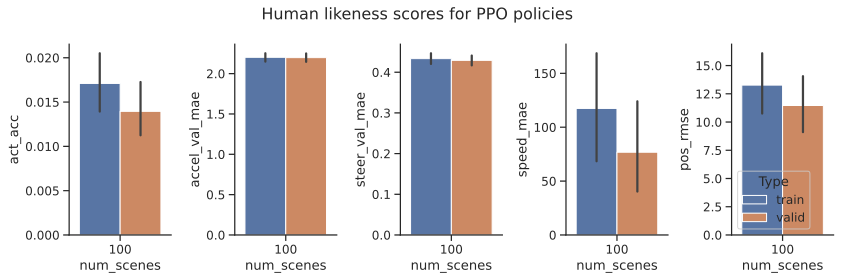

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))

fig.suptitle('Human likeness scores for PPO policies', fontsize=16)

sns.barplot(data=df_hr_rl, x='num_scenes', y='act_acc', ax=axs[0], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='accel_val_mae', ax=axs[1], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='steer_val_mae', ax=axs[2], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='speed_mae', ax=axs[3], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='pos_rmse', ax=axs[4], hue='Type', legend=True)

fig.tight_layout()
sns.despine()

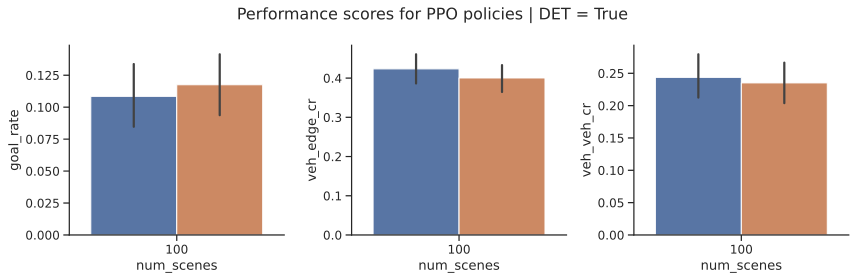

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle(f'Performance scores for PPO policies | DET = {DETERMINISTIC}', fontsize=16)

sns.barplot(data=df_hr_rl, x='num_scenes', y='goal_rate', ax=axs[0], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='veh_edge_cr', ax=axs[1], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='veh_veh_cr', ax=axs[2], hue='Type', legend=False)

fig.tight_layout()
sns.despine()

In [35]:
len(df_hr_rl['traffic_scene'].unique())

199

In [39]:
df_hr_rl[df_hr_rl['Type'] == 'train'].groupby('traffic_scene')['goal_rate'].mean()) / 199

0.04001020194409743

In [25]:
df_hr_rl.head()

,run_id,reg_coef,traffic_scene,agent_id,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,Type,num_scenes
0,None,0.0,tfrecord-00001-of-01000_307.json,0,0.0750,2.326923,0.314103,7.041383,1.820937,0.0,0.0,0.0,train,100
1,None,0.0,tfrecord-00001-of-01000_307.json,1,0.0125,1.973684,0.350000,3.827434,1.104908,0.0,1.0,0.0,train,100
2,None,0.0,tfrecord-00001-of-01000_307.json,9,0.0000,2.088608,0.412025,8.245358,2.618147,0.0,0.0,0.0,train,100
3,None,0.0,tfrecord-00004-of-01000_378.json,0,0.0000,2.421053,0.503509,5.061539,1.413594,0.0,0.0,0.0,train,100
4,None,0.0,tfrecord-00004-of-01000_378.json,2,0.0000,1.500000,0.425000,1.942767,0.621620,1.0,0.0,0.0,train,100


In [ ]:
df_hr_rl.groupby('traffic_scene')

In [27]:
df_hr_rl.groupby('traffic_scene')[performance_metrics].mean()

,goal_rate,veh_edge_cr,veh_veh_cr
traffic_scene,,,
tfrecord-00001-of-01000_307.json,0.000000,0.333333,0.000000
tfrecord-00004-of-00150_246.json,0.333333,0.666667,0.000000
tfrecord-00004-of-01000_378.json,0.200000,0.400000,0.000000
tfrecord-00005-of-00150_192.json,0.111111,0.333333,0.222222
tfrecord-00005-of-01000_423.json,0.000000,1.000000,0.000000
...,...,...,...
tfrecord-00144-of-00150_65.json,0.000000,0.857143,0.000000
tfrecord-00146-of-00150_228.json,0.000000,0.571429,0.428571
tfrecord-00147-of-00150_191.json,0.000000,0.500000,0.000000


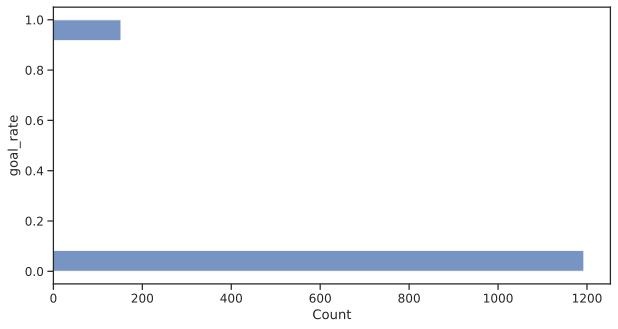

In [23]:
sns.histplot(data=df_hr_rl, y='goal_rate',);

In [10]:
#plot_agent_trajectory(df_rl_trajs_sub[df_rl_trajs_sub['agent_id'] == 0], evaluator.env.action_space.n)

In [11]:
#plot_agent_trajectory(df_rl_trajs_sub[df_rl_trajs_sub['agent_id'] == 1], evaluator.env.action_space.n)

### 3.2 Make videos of top 10 most difficult scenes / top 10 easiest scenes


In [8]:
NUM_VIDEOS = 5

df_hr_rl.sort_values('goal_rate').head()

,run_id,traffic_scene,agents_controlled,reg_coef,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,class
48,None,tfrecord-00061-of-01000_223.json,2,0.0,0.031250,1.807229,0.345783,5.234700,1.430212,0.0,0.5,0.0,HR_RL: 0.0
59,None,tfrecord-00072-of-01000_20.json,4,0.0,0.003125,2.354651,0.415116,6.995587,2.723312,0.0,0.0,1.0,HR_RL: 0.0
57,None,tfrecord-00070-of-01000_158.json,3,0.0,0.000000,1.330189,0.587736,5.233993,0.280898,0.0,1.0,0.0,HR_RL: 0.0
56,None,tfrecord-00069-of-01000_193.json,5,0.0,0.020000,1.956522,0.281522,169.067436,768.979722,0.0,0.8,0.0,HR_RL: 0.0
84,None,tfrecord-00095-of-01000_204.json,2,0.0,0.006250,2.000000,0.449383,5.101935,0.509049,0.0,0.5,0.0,HR_RL: 0.0


In [15]:
worst_scenes = df_hr_rl_all.sort_values('goal_rate')['traffic_scene'].values[:NUM_VIDEOS]

render_traffic_scenes(
    eval_scenes=worst_scenes,
    policy=policy,
    run_name="RL_S100_worst",
    deterministic=False,
)

Evaluating policy on tfrecord-00061-of-01000_223.json...
Evaluating policy on tfrecord-00072-of-01000_20.json...
Evaluating policy on tfrecord-00070-of-01000_158.json...
Evaluating policy on tfrecord-00069-of-01000_193.json...
Evaluating policy on tfrecord-00095-of-01000_204.json...


In [16]:
worst_scenes = df_hr_rl_all.sort_values('goal_rate')['traffic_scene'].values[:NUM_VIDEOS]

render_traffic_scenes(
    eval_scenes=worst_scenes,
    policy=policy,
    run_name="RL_S100_worst",
    deterministic=True,
)

Evaluating policy on tfrecord-00061-of-01000_223.json...
Evaluating policy on tfrecord-00072-of-01000_20.json...
Evaluating policy on tfrecord-00070-of-01000_158.json...
Evaluating policy on tfrecord-00069-of-01000_193.json...
Evaluating policy on tfrecord-00095-of-01000_204.json...


: 

In [10]:
best_scenes = df_hr_rl_all.sort_values('goal_rate', ascending=False)['traffic_scene'].values[:NUM_VIDEOS]

render_traffic_scenes(
    eval_scenes=best_scenes,
    policy=policy,
    run_name="RL_S100_best",
    deterministic=False,
)

Evaluating policy on tfrecord-00019-of-01000_117.json...
Evaluating policy on tfrecord-00059-of-01000_12.json...
Evaluating policy on tfrecord-00111-of-01000_359.json...
Evaluating policy on tfrecord-00079-of-01000_207.json...
Evaluating policy on tfrecord-00024-of-01000_33.json...


### Is there a trade-off between human likeness and performance? | **Pareto plots**

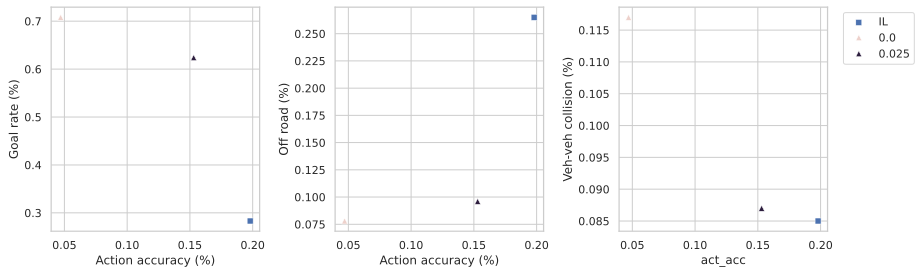

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Accuracy to goal rate
# IL
sns.scatterplot(data=df_il_agg, x='act_acc', y='goal_rate', marker='s', label='IL', ax=axes[0], legend=False)
# HR-RL
sns.scatterplot(data=df_hr_rl_agg, x='act_acc', y='goal_rate', marker='^', hue='reg_coef', ax=axes[0], legend=False)

# Accuracy to off road
# IL
sns.scatterplot(data=df_il_agg, x='act_acc', y='veh_edge_cr', marker='s', label='IL', ax=axes[1], legend=False)
# HR-RL
sns.scatterplot(data=df_hr_rl_agg, x='act_acc', y='veh_edge_cr', marker='^', hue='reg_coef', ax=axes[1], legend=False)


# Accuracy to collision rate
# IL
sns.scatterplot(data=df_il_agg, x='act_acc', y='veh_veh_cr', marker='s', label='IL', ax=axes[2],)
# HR-RL
sns.scatterplot(data=df_hr_rl_agg, x='act_acc', y='veh_veh_cr', marker='^', hue='reg_coef', ax=axes[2])

axes[0].grid(True) 
axes[1].grid(True) 
axes[2].grid(True) 
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axes[0].set_xlabel('Action accuracy (%)')
axes[0].set_ylabel('Goal rate (%)')
axes[1].set_xlabel('Action accuracy (%)')
axes[1].set_ylabel('Off road (%)')
axes[2].set_ylabel('Veh-veh collision (%)')
plt.tight_layout()

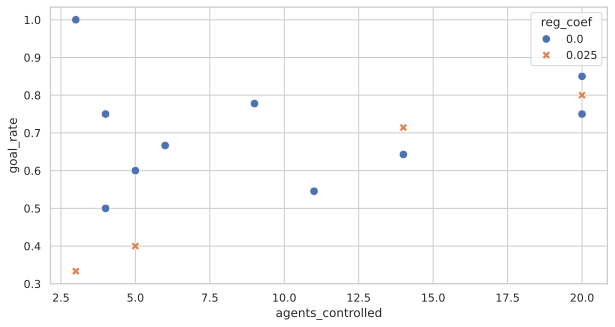

In [85]:
sns.scatterplot(data=df_hr_rl_all, x="agents_controlled", y="goal_rate", hue='reg_coef', palette="deep", style='reg_coef', s=70);

In [79]:
df_hr_rl_all.value_counts('reg_coef')

reg_coef
0.000    10
0.025    10
Name: count, dtype: int64